In [72]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from utils import *
from tqdm.auto import tqdm
sns.set_context('notebook')
plt.rcParams['font.family'] = ['Arial Unicode MS']

# preprocess and load data
filepath = 'train_data.pkl'
if not os.path.exists(filepath):
    general_process(output_filepath=filepath)
with open(filepath, 'rb') as fin:
    df = pickle.load(fin)
df.head(1)

# normalize all waveforms to the range [-1, 1] for better classification
df['flux_density'] = df['flux_density'].apply(
    lambda x: 2 * (x - np.min(x)) / (np.max(x) - np.min(x)) - 1)

In [2]:
type(df.iloc[5242].values[-1][0])

numpy.float64

In [3]:
df = df[df['flux_density'].apply(lambda x: np.isnan(x).any()) == False]
df

,type_material,temp,freq,core_loss,type_waveform,flux_density
0,1,25,50030,1997.955250,正弦波,"[0.007229411718616685, 0.013356668196946586, 0..."
1,1,25,50020,2427.749830,正弦波,"[-0.017401803085983714, -0.011260965531305178,..."
2,1,25,50020,3332.725760,正弦波,"[-0.1067064942355489, -0.10063346699505071, -0..."
3,1,25,50020,4502.908007,正弦波,"[-0.01264489442577299, -0.0065412424106490175,..."
4,1,25,50030,6063.023248,正弦波,"[0.010796261772680005, 0.016893932840702508, 0..."
...,...,...,...,...,...,...
12395,4,90,199190,20604.900210,梯形波,"[-0.524328027853811, -0.5121888519525644, -0.5..."
12396,4,90,199190,26504.284280,梯形波,"[-0.5287021385544561, -0.5164912391894997, -0...."
12397,4,90,199190,46232.491530,梯形波,"[-0.5261743569406825, -0.5140393388355926, -0...."
12398,4,90,199190,61458.085900,梯形波,"[-0.5238956623852282, -0.5117795852883722, -0...."


# 问题一： 励磁波形分类

输入一个长度为1024的序列，输出一个类别（正弦波0、三角波1、梯形波2）

In [4]:
df[df['type_waveform'] == '梯形波'].head(1)

,type_material,temp,freq,core_loss,type_waveform,flux_density
2370,1,25,50060,12568.70593,梯形波,"[-0.533595069356785, -0.5221503770225163, -0.5..."


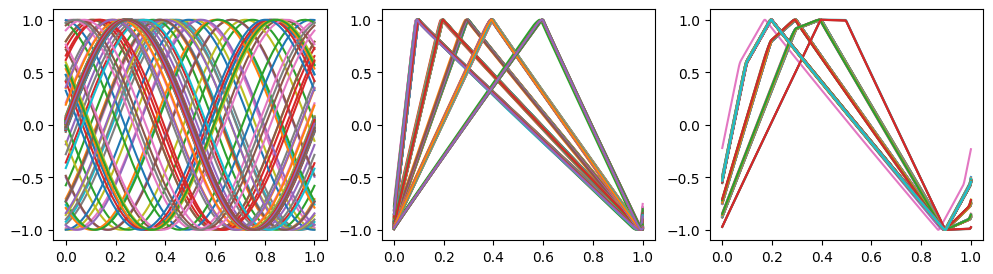

In [5]:
# iterate over the range with a step of 10, ensuring the index is within bounds
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
xs = np.linspace(0, 1, 1024)
for type_waveform, ax in zip(['正弦波', '三角波', '梯形波'], axes):
    for i in range(1, min(10000, len(df[df['type_waveform'] == type_waveform])), 10):
        ax.plot(xs, df[df['type_waveform'] == type_waveform]['flux_density'].iloc[i])
plt.savefig('waveform.png', dpi=500, bbox_inches='tight')

## 尝试一：傅立叶变换、时频谱图

/Users/durui/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


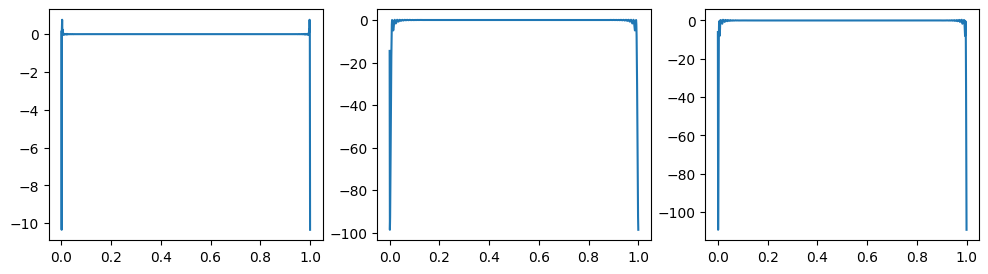

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
for type_waveform, ax in zip(['正弦波', '三角波', '梯形波'], axes):
    ax.plot(xs, np.fft.fft(df[df['type_waveform'] == type_waveform]['flux_density'].iloc[1]))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

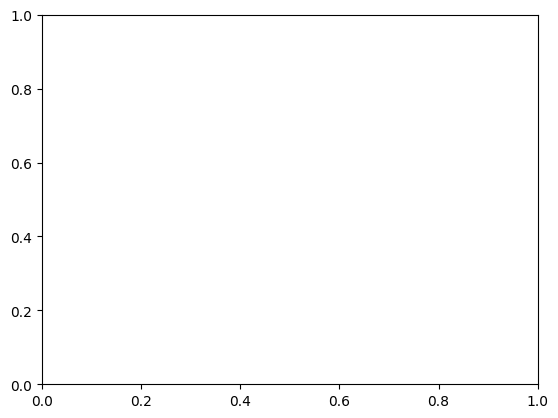

In [30]:
for type_waveform in ['正弦波', '三角波', '梯形波']:
    plt.specgram(xs, df[df['type_waveform'] == type_waveform]['flux_density'].iloc[1])

## 尝试二：斜率变化、拐点情况

[]
[7]
[3, 7, 36]


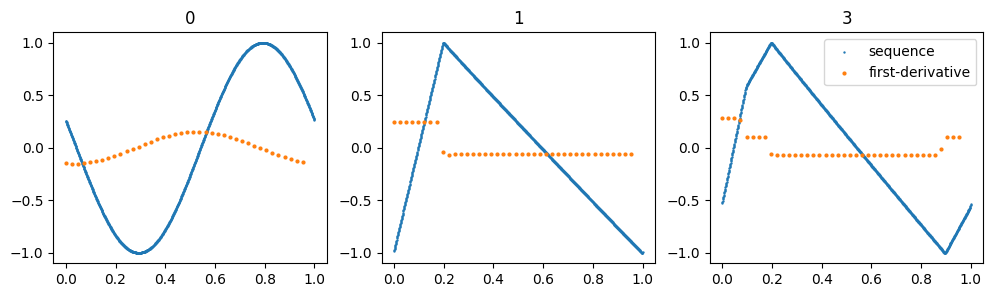

In [23]:
def break_counter(sequence, step=25, eps=0.05):
    """ count the number of the "change" 
    of the first_derivative is bigger than eps """
    first_derivative = np.diff(sequence[::step])
    # second_derivative = np.diff(first_derivative)
    pivots = []
    for j in range(len(first_derivative) - 1):
        if np.abs(first_derivative[j+1] - first_derivative[j]) > eps:
            if not pivots or j - pivots[-1] > 2:
                pivots.append(j)
    print(pivots)
    return len(pivots)


fig, axes = plt.subplots(1, 3, figsize=(12, 3))
step = 25
for type_waveform, ax in zip(['正弦波', '三角波', '梯形波'], axes):
    sequence = df[df['type_waveform'] == type_waveform].sample(1)['flux_density'].values[0]
    first_derivative = np.diff(sequence[::step])
    ax.scatter(xs, sequence, label='sequence', s=0.5)
    ax.scatter(xs[::step][:-1], first_derivative, label='first-derivative', s=4)
    # count the number of the "change" of the first_derivative is bigger than eps
    ax.set_title(f'{break_counter(sequence, step=step, eps=0.075)}')
plt.legend()
plt.show()

In [8]:
df.iloc[8603]

type_material                                                    4
temp                                                            25
freq                                                        354610
core_loss                                              460799.9781
type_waveform                                                  三角波
flux_density     [-0.9725430506212505, -0.9669830890210004, -0....
Name: 11603, dtype: object

  0%|          | 0/10000 [00:00<?, ?it/s]

[]
[6]
[3, 7, 35]
[]
[3]
[3, 7, 36]
[]
[2]
[11, 15, 35]
[]
[7]
[3, 7, 35]
[]
[7]
[3, 7, 35]
[]
[7]
[11, 15, 35]
[]
[2]
[3, 7, 35]
[]
[3]
[7, 11, 35]
[]
[2]
[3, 7, 36]
[]
[11]
[7, 11, 35]
[]
[2]
[3, 7, 35]
[]
[2]
[3, 7, 35]
[]
[3]
[7, 11, 36]
[]
[10]
[3, 7, 36]
[]
[3]
[11, 15, 36]
[]
[2]
[3, 7, 35]
[]
[3]
[3, 7, 35]
[]
[15]
[3, 7, 35]
[]
[7]
[3, 7, 35]
[]
[2]
[3, 7, 35]
[]
[7]
[3, 7, 35]
[]
[7]
[3, 7, 35]
[]
[15]
[3, 7, 35]
[]
[7]
[3, 7, 36]
[]
[3]
[3, 7, 35]
[]
[11]
[11, 15, 36]
[]
[15]
[7, 11, 36]
[]
[2]
[3, 7, 35]
[]
[3]
[3, 7, 35]
[]
[2]
[3, 7, 35]
[]
[2]
[3, 7, 35]
[]
[3]
[3, 7, 35]
[]
[2]
[3, 7, 35]
[]
[23]
[3, 7, 35]
[]
[2]
[3, 7, 35]
[]
[2]
[11, 15, 35]
[]
[15]
[7, 11, 35]
[]
[23]
[3, 7, 35]
[]
[2]
[11, 15, 35]
[]
[2]
[3, 7, 35]
[]
[15]
[3, 7, 35]
[]
[2]
[3, 7, 35]
[]
[7]
[3, 7, 36]
[]
[3]
[3, 7, 35]
[]
[3]
[11, 15, 36]
[]
[3]
[7, 11, 35]
[]
[7]
[7, 11, 35]
[]
[2]
[3, 7, 35]
[]
[2]
[11, 15, 36]
[]
[2]
[3, 7, 35]
[]
[7]
[3, 7, 35]
[]
[7]
[15, 19, 36]
[]
[7]
[3, 7, 35]
[]
[2]
[7, 

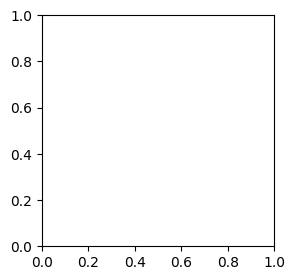

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
for _ in tqdm(range(10_000)):
    sstep, eeps = 25, 0.05
    sequence = df[df['type_waveform'] == '正弦波'].sample(1)['flux_density'].values[0]
    assert break_counter(sequence, step=sstep, eps=eeps) == 0

    record = df[df['type_waveform'] == '三角波'].sample(1)
    sequence = record.iloc[0, -1]
    break_count = break_counter(sequence, step=sstep, eps=eeps)
    if break_count not in [1, 2]:
        print(break_count, record)
        ax.scatter(xs, sequence, s=0.5)
        ax.scatter(xs[::step][:-1], first_derivative, s=4)
        plt.show()
        break

    record = df[df['type_waveform'] == '梯形波'].sample(1)
    sequence = record.iloc[0, -1]
    break_count = break_counter(sequence, step=sstep, eps=eeps)
    if break_count not in [3, 4]:
        print(break_count, record)
        ax.scatter(xs, sequence, s=0.5)
        ax.scatter(xs[::step][:-1], first_derivative, s=4)
        plt.show()
        break
plt.show()

## 测试

特别把附件二中样本序号为：1, 5, 15, 25, 35, 45, 55, 65, 75, 80 的分类结果，以表格形式呈现在论文正文中。

In [84]:
test_df = pd.read_excel('dataset/附件二（测试集）.xlsx')
test_df.rename(columns={'0（磁通密度B，T）': 0}, inplace=True)
test_df['flux_density'] = test_df.iloc[:, 4:].apply(
    lambda r: r.values, axis=1)
test_df.drop(columns=[i for i in range(1024)], inplace=True)
# normalize all waveforms to the range [-1, 1] for better classification
test_df['flux_density'] = test_df['flux_density'].apply(
    lambda x: 2 * (x - np.min(x)) / (np.max(x) - np.min(x)) - 1)
test_df.head()

,序号,温度，oC,频率，Hz,磁芯材料,flux_density
0,1,25,56180,材料1,"[-0.9429278162336249, -0.9229889379590293, -0...."
1,2,25,125890,材料1,"[-0.9312517683534196, -0.9112330452007968, -0...."
2,3,25,224180,材料1,"[-0.9028416913766483, -0.8820358289679819, -0...."
3,4,25,282480,材料1,"[-0.8595153353572332, -0.8393062754266409, -0...."
4,5,50,199170,材料1,"[-0.9211476973254586, -0.9006206833456822, -0...."


In [89]:
type2name = {0: '正弦波', 1: '三角波', 2: '梯形波'}
counter2type = {0: 0, 1: 1, 2: 1, 3: 2, 4: 2, }

test_df['励磁波形'] = test_df.apply(lambda x: counter2type[break_counter(x['flux_density'], step=25, eps=0.05)], axis=1)
test_df.head()
test_df.to_excel('test_df.xlsx', index=False)

[3]
[3]
[2]
[2]
[2]
[3, 7, 35]
[3, 7, 35]
[3, 7, 35]
[3, 7, 36]
[3, 7, 36]
[]
[]
[]
[]
[]
[3]
[2]
[2]
[2]
[3]
[3]
[6]
[11]
[7]
[11]
[]
[]
[]
[]
[]
[11, 15, 35]
[7, 11, 35]
[3, 7, 36]
[7, 11, 36]
[7, 11, 36]
[15]
[7]
[7]
[15]
[15]
[3, 7, 35]
[15]
[11, 15, 35]
[7, 11, 36]
[11, 15, 36]
[]
[]
[]
[]
[]
[3]
[11]
[11]
[7]
[6]
[11]
[11]
[3]
[2]
[15]
[2]
[7]
[7]
[2]
[3]
[2]
[7]
[2]
[2]
[7]
[23]
[3, 7, 35]
[3, 7, 35]
[15]
[23]
[]
[]
[]
[]
[]


/var/folders/hq/mrh1wvlx1r9crbtgy7q4hfbc0000gn/T/ipykernel_34548/215761384.py:6: UserWarning: Pandas requires version '3.0.5' or newer of 'xlsxwriter' (version '3.0.2' currently installed).
  test_df.to_excel('test_df.xlsx', index=False)


In [90]:
sequence = test_df.iloc[i-1]['flux_density']
len(sequence)

1024

[3]
[2]
[]
[11]
[7, 11, 36]
[11, 15, 36]
[6]
[3]
[23]
[]


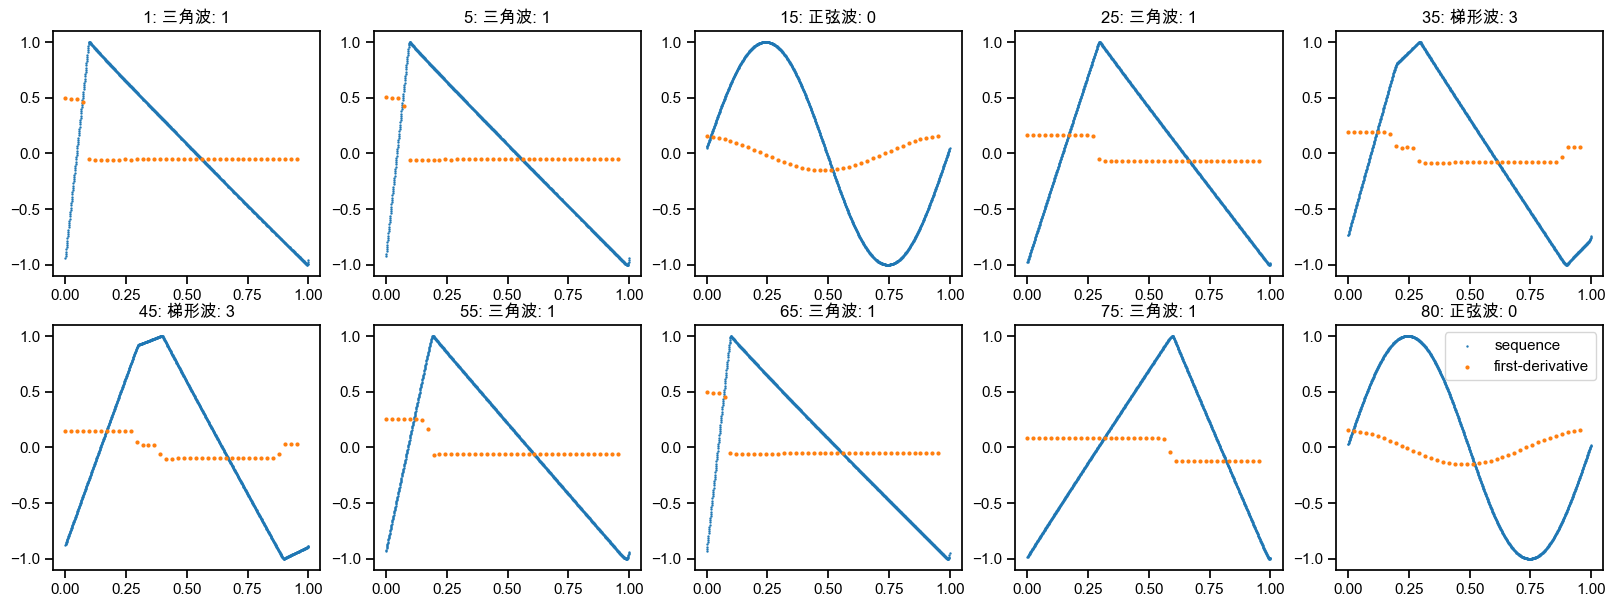

In [91]:
xs = np.linspace(0, 1, 1024)
fig, axes = plt.subplots(2, 5, figsize=(20, 7))
for i, ax in zip([1, 5, 15, 25, 35, 45, 55, 65, 75, 80], axes.flatten()):
    sequence = test_df.iloc[i-1]['flux_density']
    sequence = np.array([float(x) for x in sequence])  # convert each element to float and then to numpy array
    first_derivative = np.diff(sequence[::25])
    ax.scatter(xs, sequence, label='sequence', s=0.5)
    ax.scatter(xs[::step][:-1], first_derivative, label='first-derivative', s=4)
    ax.set_title(f'{i}: {type2name[test_df.iloc[i-1]["励磁波形"]]}: {break_counter(sequence)}')
plt.legend()
plt.show()

## 参数设定

In [92]:
set_step = [5, 8, 16, 25, 40, 64, 128]
set_eps = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]